In [1]:
import pandas as pd
import numpy as np
import sys
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import seaborn as sns
import itertools
import zipfile
import os
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

In [3]:
zip_files = ['test1','train']
for zip_file in zip_files:
    with zipfile.ZipFile("../input/dogs-vs-cats/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))


test1 unzipped
train unzipped


In [4]:
img_folder = "../working/train"
file_name = os.listdir(img_folder)
width = 150
height = 150

In [5]:
file_name[0:5]

['cat.12253.jpg',
 'dog.7619.jpg',
 'dog.4163.jpg',
 'cat.941.jpg',
 'cat.11798.jpg']

In [6]:
filenames = os.listdir("../working/train")
filepath=[]
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append("1")
    else:
        categories.append("0")
    filepath.append(os.path.join("../working/train", filename))
df = pd.DataFrame({
    'filename': filepath,
    'category': categories
})

In [7]:
df.head()

,filename,category
0,../working/train/cat.12253.jpg,0
1,../working/train/dog.7619.jpg,1
2,../working/train/dog.4163.jpg,1
3,../working/train/cat.941.jpg,0
4,../working/train/cat.11798.jpg,0


In [8]:
df['category'].value_counts()

0    12500
1    12500
Name: category, dtype: int64

<AxesSubplot:xlabel='category', ylabel='count'>

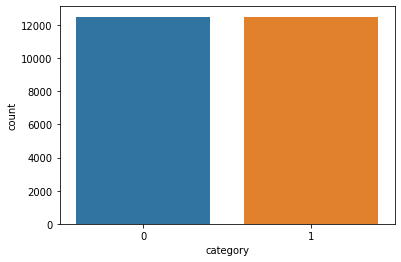

In [9]:
sns.countplot(data=df, x=df['category'])

In [10]:
root_dir = "./train/"
def show_image(class_name, examples=2):
    labels_df=df
#     train_images_path=os.path.join(root_dir)
#     print(train_images_path)
    image_list = labels_df[labels_df['category'] == class_name]['filename'].sample(frac=1)[:examples].to_list()
    plt.figure(figsize=(20,10))
    for i, img in enumerate(image_list):
        full_path = os.path.join(img)
        img = Image.open(full_path)
        plt.subplot(1 ,examples, i%examples +1)
        plt.axis('off')
        plt.imshow(img)
        plt.title(class_name)

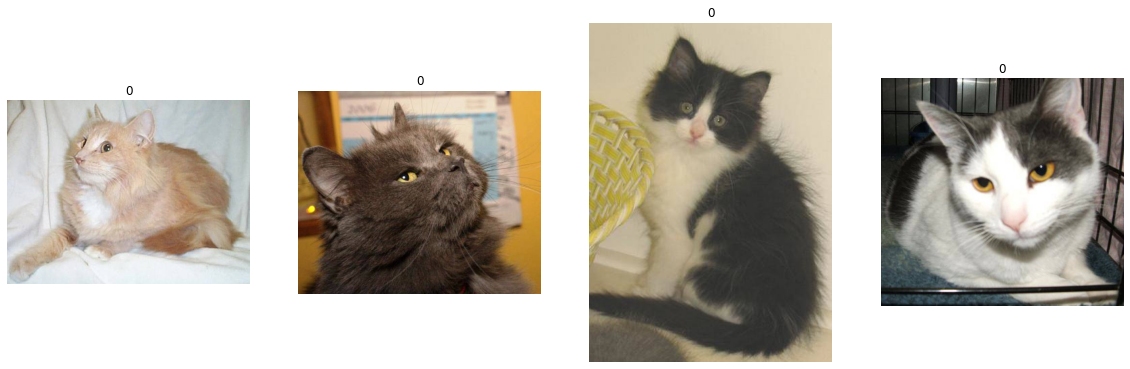

In [11]:
show_image(class_name="0", examples=4)

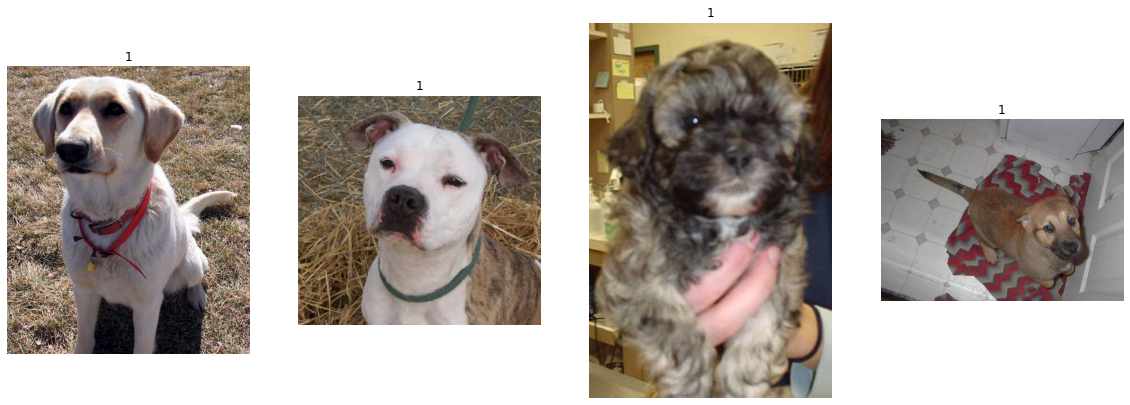

In [12]:
show_image(class_name="1", examples=4)

In [13]:
train, test = train_test_split(df, test_size=0.2, random_state=seed)

In [14]:
train.head()

,filename,category
10263,../working/train/cat.10058.jpg,0
18409,../working/train/dog.5857.jpg,1
13047,../working/train/cat.9485.jpg,0
21371,../working/train/dog.6187.jpg,1
16392,../working/train/cat.6300.jpg,0


In [15]:
train_datagen = ImageDataGenerator(
rotation_range=30,
rescale=1./255,
shear_range=0.1,
zoom_range=0.4,
horizontal_flip=True,
width_shift_range=0.1,
height_shift_range=0.1)

train_datagenerator = train_datagen.flow_from_dataframe(dataframe=train,
                                                      x_col='filename',
                                                      y_col='category',
                                                      target_size=(width,height),
                                                      class_mode='binary',
                                                       batch_size=150)

Found 20000 validated image filenames belonging to 2 classes.


In [16]:
test_datagenerator = train_datagen.flow_from_dataframe(dataframe=test,
                                                      x_col='filename',
                                                      y_col='category',
                                                      target_size=(width,height),
                                                      class_mode='binary',
                                                       batch_size=150)

Found 5000 validated image filenames belonging to 2 classes.


In [17]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(width,height,3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

2022-08-20 18:34:17.997929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 18:34:18.138033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 18:34:18.139021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 18:34:18.141019: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

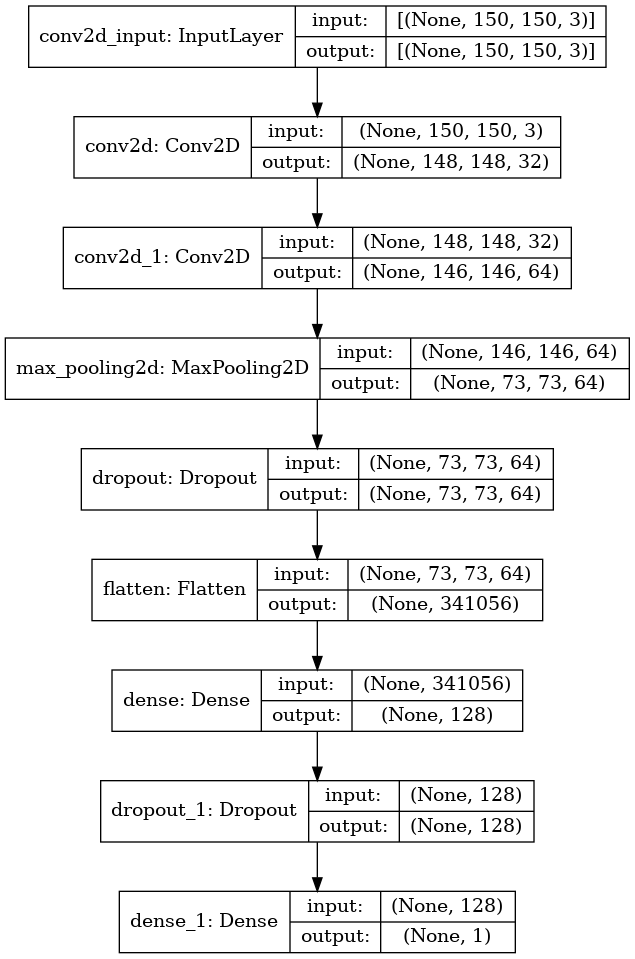

In [18]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convent.png', show_shapes=True, show_layer_names=True)
Image(filename='convent.png')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 10.9 MB/s eta 0:00:00


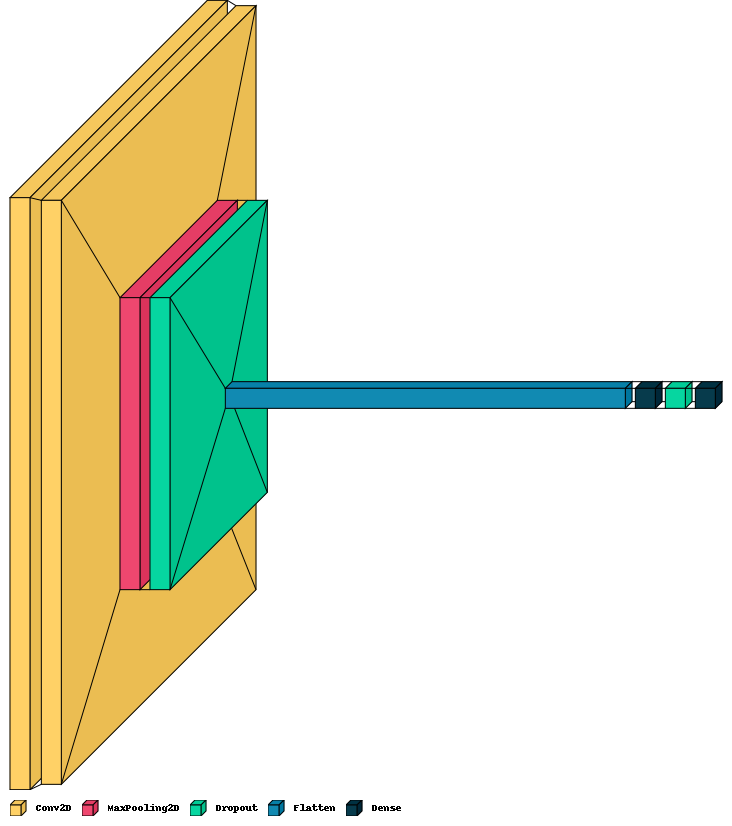

In [19]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True)

In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 341056)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               43655296  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [21]:
History = model.fit(train_datagenerator,
                   epochs=10,
                   validation_data=test_datagenerator,
                   validation_steps=test.shape[0]/150,
                   steps_per_epoch=train.shape[0]/150)

2022-08-20 18:34:38.453150: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-08-20 18:34:41.531843: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


133/133 [==============================] - 228s 2s/step - loss: 0.8842 - accuracy: 0.5946 - val_loss: 0.6391 - val_accuracy: 0.6744
Epoch 2/10
133/133 [==============================] - 219s 2s/step - loss: 0.6068 - accuracy: 0.6750 - val_loss: 0.5614 - val_accuracy: 0.6990
Epoch 3/10
133/133 [==============================] - 214s 2s/step - loss: 0.5887 - accuracy: 0.6870 - val_loss: 0.5580 - val_accuracy: 0.7038
Epoch 4/10
133/133 [==============================] - 215s 2s/step - loss: 0.5632 - accuracy: 0.7078 - val_loss: 0.5342 - val_accuracy: 0.7194
Epoch 5/10
133/133 [==============================] - 214s 2s/step - loss: 0.5548 - accuracy: 0.7128 - val_loss: 0.5381 - val_accuracy: 0.7238
Epoch 6/10
133/133 [==============================] - 214s 2s/step - loss: 0.5444 - accuracy: 0.7227 - val_loss: 0.5257 - val_accuracy: 0.7360
Epoch 7/10
133/133 [==============================] - 216s 2s/step - loss: 0.5346 - accuracy: 0.7301 - val_loss: 0.5003 - val_accuracy: 0.7538
Epoch 8/10

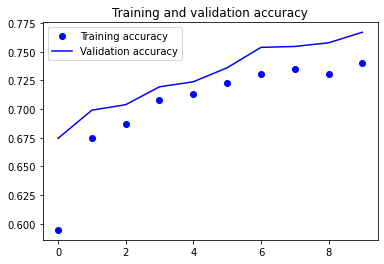

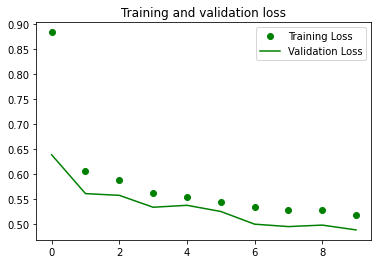

In [22]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
loss = History.history['loss']
val_loss = History.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
model.save_weights("model.h5")

In [24]:
test_loss, test_accuracy = model.evaluate(test_datagenerator, steps=len(test_datagenerator), verbose=1)
print("Loss: %.3f" %(test_loss*100.0))
print("Accuracy: %.3f" %(test_accuracy*100.0))

34/34 [==============================] - 43s 1s/step - loss: 0.4882 - accuracy: 0.7676
Loss: 48.821
Accuracy: 76.760
